# Task 3: Object detection and Tracking
For this task you will 
1. Use YOLO to detect people
2. Estimate the distance to the detected persons
3. Track the detected persons using a Kalman Filter

## Important hints to successfully complete this task
- **Don‘t** change blocks except you are explicitly asked to do so
- Add your solution in the #TODO parts
- To pass this task, **every cell** of the notebook needs to be executable i.e. runs without errors
- The notebooks are manually checked, if the task was understood and solved in a reasonable way

# Import modules

If you are missing modules install them to you selected kernel via `pip`.

In [1]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2  # Import cv2 library for image processing
import pyrealsense2 as rs # Import realsense python library
import numpy as np 
from IPython.display import clear_output, display
import time
from PIL import Image

## 3.1 Start the RealSense and view the output

Attach a realsense camera to the pc on which you are executing this notebook and check if the stream works by executing the cell underneath.


In [2]:
# Create a new pipeline object for streaming data
pipeline = rs.pipeline()

# Create a configuration object to configure the streams
config = rs.config()

# Enable color stream with a resolution of 640x480, BGR8 format, and a frame rate of 30 FPS
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

# Enable depth stream with a resolution of 640x480, Z16 format, and a frame rate of 30 FPS
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)

# Start the pipeline with the configuration
pipeline.start(config)

# Enable interactive mode in matplotlib for real-time updating
plt.ion()

# Start an infinite loop to continuously fetch frames and display the color stream
try:
    while True:
        # Wait for a new set of frames (color and depth)
        frames = pipeline.wait_for_frames()

        # Extract the color frame from the frames object
        color_frame = frames.get_color_frame()

        # Convert the color frame to a numpy array for visualization
        color_image = np.asanyarray(color_frame.get_data())

        # Convert BGR to RGB for correct color representation in matplotlib
        color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)

        # Clear the previous output in the interactive mode to update the plot
        clear_output(wait=True)

        # Display the color image using matplotlib
        plt.imshow(color_image)
        plt.axis('off')  # Turn off the axis labels for a clean view
        plt.show()

        # Sleep for 0.01 seconds to control the frame rate (approximately 100 FPS)
        time.sleep(0.01)  # Adjust sleep time to control the FPS

# Handle keyboard interrupt gracefully (e.g., pressing Ctrl+C to stop)
except KeyboardInterrupt:
    pass

# Stop the pipeline after the loop ends
pipeline.stop()

# Print a message indicating that streaming has been stopped
print("Streaming stopped.")

Streaming stopped.


# 3.2 Load the YOLO model and detect object with the RealSense

In addition to simply watching the video stream of the realsense camera load a pretrained yolo model. Use the model to predict bounding boxes for people.

In [3]:
def main_loop(estimate_depth=False, kalman_tracking=False):

    ### TODO: load the yolo model, hint look into ultralytics documentation
    model = YOLO("yolo11n.pt")
    ###

    # realsense config
    pipeline = rs.pipeline()
    config = rs.config()
    config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
    config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
    pipeline.start(config)
    plt.ion()

    # create var to store last bounding box
    last_bbox = (0,0,0,0)

    try:
        while True:
            
            # receive color and depth frames
            frames = pipeline.wait_for_frames()
            color_frame = frames.get_color_frame()
            color_image = np.asanyarray(color_frame.get_data())
            color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
            depth_frame = frames.get_depth_frame()
            depth_image = np.asanyarray(depth_frame.get_data())

            ### TODO: run yolo model to predict a bounding boxes only for people, select only the best detection
            results = model(color_image, classes = [0])[0]
            
            ###

            result_img = results.plot()

            # create var to store detected positions
            detected_position = None

            # process the results
            for box in results.boxes:
                # get bounding box coordinates and store them
                x1, y1, x2, y2 = map(int, box.xyxy[0]) 
                
                ### TODO: calculate the center of the bounding boxes and store the center detections in the tuple detected_positions like (x_value, y_value)
                center_x = (x1 + x2)// 2
                center_y = (y1 + y2) // 2
                detected_position = (center_x, center_y)
                ###

                # store detections
                last_bbox = (x1, y1, x2, y2)

                # check if bbox is for a person and  if depth should be estimated
                if int(box.cls) == 0 and estimate_depth:
                    # estimate distances
                    person_distance_center = dist_to_center(depth_image, center_x, center_y)
                    person_distance_mean, person_distance_median = dist_to_cutout(depth_image, x1, x2, y1, y2)

                    # create distance labels and put on image
                    label_distance_center = f'distance center: {person_distance_center}'  # model class names list for labels
                    label_distance_mean = f'distance mean: {person_distance_mean}'  # model class names list for labels
                    label_distance_median = f'distance median: {person_distance_median}'  # model class names list for labels
                    cv2.putText(result_img, label_distance_center, (x1, y1 + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                    cv2.putText(result_img, label_distance_mean, (x1, y1 + 45), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                    cv2.putText(result_img, label_distance_median, (x1, y1 + 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            # check if kalman filter tracking should be activated
            if kalman_tracking:
                # track with kalman filter
                pred_x_min, pred_y_min, pred_x_max, pred_y_max = kalman_filter_tracking(detected_position, last_bbox)
                # draw the predicted bounding box (blue)
                cv2.rectangle(result_img, (pred_x_min, pred_y_min), (pred_x_max, pred_y_max), (0, 0, 255), 2)
        
            # plot image
            clear_output(wait=True)
            plt.imshow(result_img)
            plt.axis('off')
            plt.show()

            # update frequency
            time.sleep(0.01)

    except KeyboardInterrupt:
        pass

    pipeline.stop()
    print("Streaming stopped.")

Check if the tracking works by executing the main loop. But set `estimate_depth` parameter to false as we did not define the needed functions for this functionality until now.

In [4]:
main_loop(estimate_depth=False, kalman_tracking=False)

Streaming stopped.


# 3.3 Calculate the distance to a person
For calculating the distance you can use the depth information of the realsense camera. There are different ways to calculate the distance to an object:
1. Distance to the center of a bounding box
2. Median or mean distance to the cutout of the object

Implement the above mentioned metrics in the two following functions:

In [4]:
def dist_to_center(depth_image, x_center, y_center):
    
    ### TODO: estimate the distance to the person based on the given center and return the distance
    return depth_image[y_center, x_center]
    ###

def dist_to_cutout(depth_image, x1, x2, y1, y2):
    
    ### TODO: estimate the center of the given bounding box values and return their mean and median in this order
    distance = [depth_image[y , x] for y in range (y1,y2) for x in range (x1,x2)]
    return np.mean(distance), np.median(distance)
    ###

In [8]:
main_loop(estimate_depth=True, kalman_tracking=False)

Streaming stopped.


# 3.4 Kalman Filter
Classical tracking with YOLO is not capable of handling occlusions. Therefore we use kalman filter tracking for predicting movements of occluded people. First we define the parameters of the kalman filter

In [5]:
# Initialize Kalman filter for 2D tracking (position and velocity in X and Y)
kalman = cv2.KalmanFilter(4, 2)

### TODO: define the position measurement matrix as a numpy array
kalman.measurementMatrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0]],np.float32)
###

# Transition matrix (state transition: position and velocity)
kalman.transitionMatrix = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32)

### TODO: define process noise covariance (controls how much the prediction "trusts" previous values) and measurement noise covariance (controls how much the measurement is trusted) as numpy arrays
kalman.processNoiseCov = np.array([[0.01, 0, 0, 0], [0, 0.01, 0, 0], [0, 0, 0.01, 0], [0, 0, 0, 0.01]], np.float32)
kalman.measurementNoiseCov = np.array([[1, 0], [0, 1]],np.float32)* 0.01
###


Next we define the tracking function

In [6]:
def kalman_filter_tracking(detected_position, bbox):

    # predict the next position using kalman filter
    predicted = kalman.predict()
    predicted_x, predicted_y = int(predicted[0]), int(predicted[1])
    x_min, y_min, x_max, y_max = bbox

    # if the person is detected, correct the kalman filter
    if detected_position:
        center_x, center_y = detected_position
        # correct the kalman filter with the actual position (center of the bounding box)
        kalman.correct(np.array([[np.float32(center_x)], [np.float32(center_y)]]))

    ### TODO: draw the predicted bounding box based on the predicted center
    width = x_max - x_min
    height = y_max - y_min
    pred_x_min = int(predicted_x - width / 2)
    pred_y_min = int(predicted_y - height / 2)
    pred_x_max = int(predicted_x + width / 2)
    pred_y_max = int(predicted_y + height / 2)
    ###

    return pred_x_min, pred_y_min, pred_x_max, pred_y_max



Now we can execute the main loop again with activated kalman filter tracking

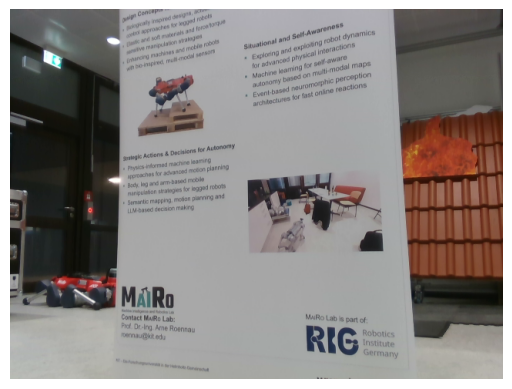


Streaming stopped.


In [7]:
main_loop(estimate_depth=False, kalman_tracking=True)